In [1]:
import cv2
import numpy as np

def get_birdeye_rgb(camera_rgb, T_base_cam, K, scale=800, margin=0.1, rotate_ccw=True):
    """
    Convert a perspective RGB image into an orthogonal bird’s-eye (top-down) view.

    Parameters
    ----------
    camera_rgb : np.ndarray
        RGB image from the camera (H x W x 3).
    T_base_cam : np.ndarray
        4x4 transformation matrix from base to camera.
    K : np.ndarray
        3x3 camera intrinsic matrix.
    scale : float, optional
        Pixels per meter for the output image (controls zoom level).
    margin : float, optional
        Padding (as a fraction of image size) around the ground projection area.
    rotate_ccw : bool, optional
        If True, rotate output image 90° counter-clockwise (for standard top-down view).

    Returns
    -------
    orthogonal_rgb : np.ndarray
        The resulting bird’s-eye (orthogonal) RGB image.
    """

    # === Compute homography from image plane to ground plane ===
    T_cam_base = np.linalg.inv(T_base_cam)
    R = T_cam_base[:3, :3]
    t = T_cam_base[:3, 3:4]
    n = np.array([[0, 0, 1]]).T
    H = R - (t @ n.T) / (n.T @ t)
    H = K @ H
    H = H / H[2, 2]

    # === Project image corners onto the ground plane ===
    h, w = camera_rgb.shape[:2]
    corners = np.array([[0, 0, 1],
                        [w, 0, 1],
                        [0, h, 1],
                        [w, h, 1]]).T
    ground_corners = np.linalg.inv(H) @ corners
    ground_corners /= ground_corners[2]
    gx, gy = ground_corners[0], ground_corners[1]

    # === Define output area and scale ===
    xmin, xmax = gx.min(), gx.max()
    ymin, ymax = gy.min(), gy.max()
    xrange = (xmin - margin*(xmax-xmin), xmax + margin*(xmax-xmin))
    yrange = (ymin - margin*(ymax-ymin), ymax + margin*(ymax-ymin))

    scale = scale / (xmax - xmin) * (xmax - xmin)  # keep as pixels per meter
    x_lin = np.linspace(xrange[0], xrange[1], int((xrange[1]-xrange[0])*scale))
    y_lin = np.linspace(yrange[1], yrange[0], int((yrange[1]-yrange[0])*scale))
    xv, yv = np.meshgrid(x_lin, y_lin)

    # === Project ground coordinates back into image pixels ===
    pts_ground = np.stack([xv, yv, np.ones_like(xv)], axis=-1).reshape(-1, 3).T
    pts_img = H @ pts_ground
    pts_img /= pts_img[2]

    map_x = pts_img[0].reshape(yv.shape).astype(np.float32)
    map_y = pts_img[1].reshape(yv.shape).astype(np.float32)

    orthogonal_rgb = cv2.remap(
        camera_rgb, map_x, map_y,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    # === Optional rotation (90° counter-clockwise) ===
    if rotate_ccw:
        orthogonal_rgb = cv2.rotate(orthogonal_rgb, cv2.ROTATE_90_COUNTERCLOCKWISE)

    return orthogonal_rgb


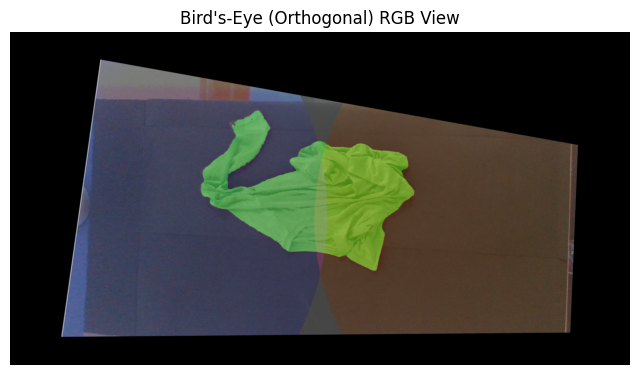

In [2]:
import matplotlib.pyplot as plt


T_base_cam = np.array([
    [ 0.05593725,  0.99685122,  0.056202,   -0.02848109],
    [ 0.93291326, -0.03212807, -0.35866508, -0.34555581],
    [-0.35573006,  0.07249433, -0.93177288,  0.90693955],
    [ 0.,          0.,          0.,          1.        ]
])

K = np.array([
    [908.21728516,   0.,         642.64819336],
    [  0.,         907.78796387, 380.05688477],
    [  0.,           0.,           1.        ]
])

# Load camera image
camera_rgb = cv2.imread("../assets/masks_rgb.png")
camera_rgb = cv2.cvtColor(camera_rgb, cv2.COLOR_BGR2RGB)

# Generate bird’s-eye image
bird_eye = get_birdeye_rgb(camera_rgb, T_base_cam, K)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(bird_eye)
plt.title("Bird's-Eye (Orthogonal) RGB View")
plt.axis("off")
plt.show()


In [3]:
import cv2
import numpy as np

def get_birdeye_rgb_and_pose(camera_rgb, T_base_cam, K, scale=800, margin=0.1, rotate_ccw=True):
    """
    Convert a perspective RGB image to an orthogonal (bird's-eye) view and
    compute the equivalent top-down camera intrinsics and extrinsics.

    Parameters
    ----------
    camera_rgb : np.ndarray
        RGB image (H x W x 3)
    T_base_cam : np.ndarray
        4x4 base-to-camera transformation
    K : np.ndarray
        3x3 camera intrinsic matrix
    scale : float
        Pixels per meter for output image (controls zoom)
    margin : float
        Padding (as fraction of the image size)
    rotate_ccw : bool
        Rotate 90° counter-clockwise for visualization

    Returns
    -------
    orthogonal_rgb : np.ndarray
        Top-down RGB image
    K_ortho : np.ndarray
        Intrinsics for the orthogonal camera
    T_base_ortho : np.ndarray
        Extrinsics for the orthogonal camera
    """

    # === Step 1: Homography ===
    T_cam_base = np.linalg.inv(T_base_cam)
    R = T_cam_base[:3, :3]
    t = T_cam_base[:3, 3:4]
    n = np.array([[0, 0, 1]]).T
    H = R - (t @ n.T) / (n.T @ t)
    H = K @ H
    H = H / H[2, 2]

    # === Step 2: Project corners to find bounds ===
    h, w = camera_rgb.shape[:2]
    corners = np.array([[0, 0, 1],
                        [w, 0, 1],
                        [0, h, 1],
                        [w, h, 1]]).T
    ground_corners = np.linalg.inv(H) @ corners
    ground_corners /= ground_corners[2]
    gx, gy = ground_corners[0], ground_corners[1]

    # === Step 3: Define output region ===
    margin = 0.1
    xmin, xmax = gx.min(), gx.max()
    ymin, ymax = gy.min(), gy.max()
    xrange = (xmin - margin*(xmax-xmin), xmax + margin*(xmax-xmin))
    yrange = (ymin - margin*(ymax-ymin), ymax + margin*(ymax-ymin))

    scale_pxpm = scale / (xmax - xmin) * (xmax - xmin)
    x_lin = np.linspace(xrange[0], xrange[1], int((xrange[1]-xrange[0])*scale_pxpm))
    y_lin = np.linspace(yrange[1], yrange[0], int((yrange[1]-yrange[0])*scale_pxpm))
    xv, yv = np.meshgrid(x_lin, y_lin)

    pts_ground = np.stack([xv, yv, np.ones_like(xv)], axis=-1).reshape(-1, 3).T
    pts_img = H @ pts_ground
    pts_img /= pts_img[2]

    map_x = pts_img[0].reshape(yv.shape).astype(np.float32)
    map_y = pts_img[1].reshape(yv.shape).astype(np.float32)

    orthogonal_rgb = cv2.remap(
        camera_rgb, map_x, map_y,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    # === Step 4: Define orthogonal camera pose ===
    # Top-down camera looking straight down from +Z direction
    height = T_base_cam[2, 3]  # camera height above ground (approx)
    R_base_ortho = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])
    T_base_ortho = np.eye(4)
    T_base_ortho[:3, :3] = R_base_ortho
    T_base_ortho[:3, 3] = np.array([0, 0, height])

    # === Step 5: Define orthogonal camera intrinsics ===
    h_out, w_out = orthogonal_rgb.shape[:2]
    fx = fy = scale_pxpm  # pixels per meter
    cx, cy = w_out / 2, h_out / 2
    K_ortho = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ])

    # === Step 6: Optional rotation (CCW) ===
    if rotate_ccw:
        orthogonal_rgb = cv2.rotate(orthogonal_rgb, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # When rotating, update intrinsics accordingly
        K_rot = np.array([
            [0, -1, h_out],
            [1,  0, 0],
            [0,  0, 1]
        ])
        K_ortho = K_rot @ K_ortho

    return orthogonal_rgb, map_x, map_y, K_ortho, T_base_ortho


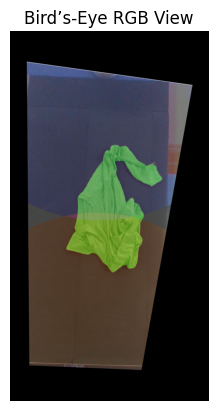

K_bird (intrinsics):
 [[8.0000e+02 0.0000e+00 8.1900e+02]
 [0.0000e+00 8.0000e+02 1.5255e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]

T_base_bird (extrinsics):
 [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.90693955]
 [0.         0.         0.         1.        ]]


In [4]:
orthogonal_rgb, map_x, map_y, K_bird, T_base_bird = get_birdeye_rgb_and_pose(camera_rgb, T_base_cam, K, rotate_ccw=False)

import matplotlib.pyplot as plt
plt.imshow(orthogonal_rgb)
plt.title("Bird’s-Eye RGB View")
plt.axis("off")
plt.show()

print("K_bird (intrinsics):\n", K_bird)
print("\nT_base_bird (extrinsics):\n", T_base_bird)


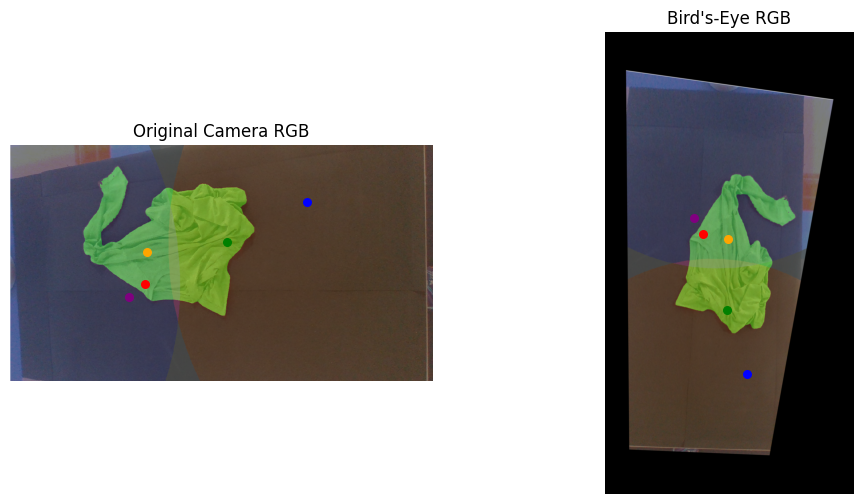

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assume these are already computed ---
# camera_rgb, orthogonal_rgb
# map_x, map_y

h, w = camera_rgb.shape[:2]
num_points = 5

# --- Step 1: Randomly select 5 pixels in the center region ---
np.random.seed(42)
margin = 0.2  # sample pixels not too close to border
us = np.random.randint(int(w*margin), int(w*(1-margin)), size=num_points)
vs = np.random.randint(int(h*margin), int(h*(1-margin)), size=num_points)

# --- Step 2: Find corresponding points in bird-eye image using remap grids ---
points_bev = []

for u, v in zip(us, vs):
    # Find the output pixel where map_x/map_y are closest to this input pixel
    dist = (map_x - u)**2 + (map_y - v)**2
    idx = np.unravel_index(np.argmin(dist), dist.shape)
    points_bev.append(idx[::-1])  # (x, y) = (col, row)

points_bev = np.array(points_bev)

# --- Step 3: Visualize with different colors ---
colors = ['red', 'blue', 'green', 'orange', 'purple']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax1.imshow(camera_rgb)
ax1.set_title("Original Camera RGB")
ax1.axis("off")
for (u, v), c in zip(zip(us, vs), colors):
    ax1.scatter(u + 0.5, v + 0.5, c=c, s=30, marker='o')  # small dot at center

# Bird-eye image
ax2.imshow(orthogonal_rgb)
ax2.set_title("Bird's-Eye RGB")
ax2.axis("off")
for (x, y), c in zip(points_bev, colors):
    ax2.scatter(x + 0.5, y + 0.5, c=c, s=30, marker='o')  # small dot at center

plt.show()


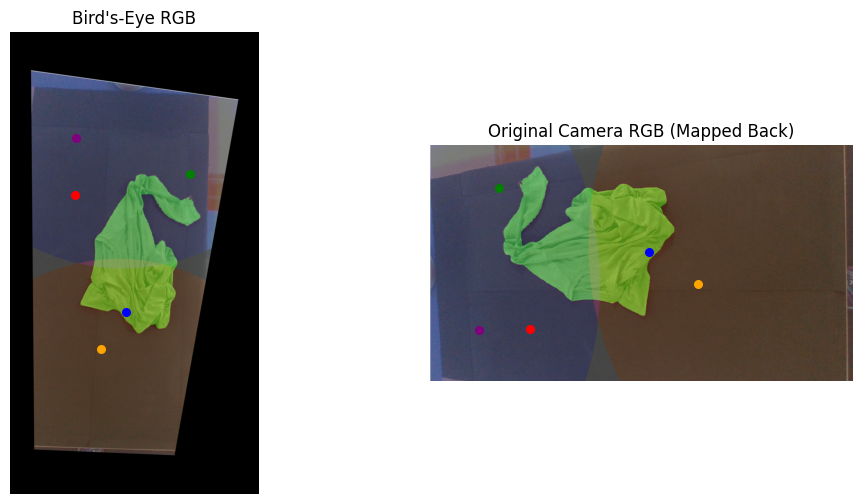

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assume these are already computed ---
# camera_rgb, orthogonal_rgb
# map_x, map_y  (size = orthogonal_rgb.shape[:2])

h_bev, w_bev = orthogonal_rgb.shape[:2]
num_points = 5

# --- Step 1: Randomly sample 5 points in bird-eye image (center region) ---
np.random.seed(42)
margin = 0.2
xs = np.random.randint(int(w_bev*margin), int(w_bev*(1-margin)), size=num_points)
ys = np.random.randint(int(h_bev*margin), int(h_bev*(1-margin)), size=num_points)

# --- Step 2: Map back to original image ---
points_orig = []

for x, y in zip(xs, ys):
    # Find closest pixel in bird-eye to the sampled point
    # map_x[y, x], map_y[y, x] contains the corresponding original image coordinates
    u = map_x[y, x]
    v = map_y[y, x]
    points_orig.append((u, v))

points_orig = np.array(points_orig)

# --- Step 3: Visualize ---
colors = ['red', 'blue', 'green', 'orange', 'purple']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bird-eye image with sampled points
ax1.imshow(orthogonal_rgb)
ax1.set_title("Bird's-Eye RGB")
ax1.axis("off")
for (x, y), c in zip(zip(xs, ys), colors):
    ax1.scatter(x + 0.5, y + 0.5, c=c, s=30, marker='o')

# Original image with mapped-back points
ax2.imshow(camera_rgb)
ax2.set_title("Original Camera RGB (Mapped Back)")
ax2.axis("off")
for (u, v), c in zip(points_orig, colors):
    ax2.scatter(u + 0.5, v + 0.5, c=c, s=30, marker='o')

plt.show()
